# Image Feature Extraction

### 下载必要的包

In [1]:
!pip install mindnlp==0.4.1 sympy==1.14.0 pillow matplotlib opencv-python

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


### 导包

In [2]:
import mindspore
from mindnlp.transformers import AutoImageProcessor, AutoModel
from PIL import Image
import numpy as np
import requests
import matplotlib.pyplot as plt
import cv2


[WARNING] DEVICE(43978,e7ffeda1a020,python):2025-08-19-19:49:39.837.713 [mindspore/ccsrc/utils/dlopen_macro.h:165] DlsymAscend] Dynamically load symbol aclprofGetSupportedFeaturesV2 failed, result = /usr/local/Ascend/ascend-toolkit/latest/lib64/libmsprofiler.so: undefined symbol: aclprofGetSupportedFeaturesV2
[WARNING] DEVICE(43978,e7ffeda1a020,python):2025-08-19-19:49:39.837.980 [mindspore/ccsrc/utils/dlopen_macro.h:165] DlsymAscend] Dynamically load symbol aclrtEventGetTimestamp failed, result = /usr/local/Ascend/ascend-toolkit/latest/lib64/libascendcl.so: undefined symbol: aclrtEventGetTimestamp
/usr/local/miniconda3/envs/feature/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/envs/feature/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.

### 加载vit模型
patch大小为16，要求输入图像大小为224，最终的patch数量为14

In [3]:
import os
# 导入镜像源
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = AutoModel.from_pretrained(
    "google/vit-base-patch16-224",
    ms_dtype=mindspore.float32,
    output_attentions=True
)
model

100%|██████████| 160/160 [00:00<00:00, 250kB/s]
68.0kB [00:00, 544kB/s]
100%|██████████| 330M/330M [03:10<00:00, 1.82MB/s]    
[WARNING] DEVICE(43978,e7ffeda1a020,python):2025-08-19-19:53:14.823.091 [mindspore/ccsrc/plugin/res_manager/ascend/mem_manager/ascend_memory_adapter.cc:123] Initialize] Free memory size is less than half of total memory size.Device 0 Device MOC total size:16367894528 Device MOC free size:7984611328 may be other processes occupying this card, check as: ps -ef|grep python
2025-08-19 19:53:45.629189: E external/org_tensorflow/tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute T which is not in the op definition: Op<name=StatelessRandomNormalV2; signature=shape:Tshape, key:uint64, counter:uint64, alg:int32 -> output:dtype; attr=dtype:type,default=DT_FLOAT,allowed=[DT_HALF, DT_BFLOAT16, DT_FLOAT, DT_DOUBLE]; attr=Tshape:type,default=DT_INT32,allowed=[DT_INT32, DT_INT64]> This may be expected if your graph generating binary is newer  than this

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear (768 -> 768)
            (key): Linear (768 -> 768)
            (value): Linear (768 -> 768)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear (768 -> 768)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear (768 -> 3072)
          (intermediate_act_fn): GELU(approximate='none')
        )
        (output): ViTOutput(
          (dense): Linear (3072 -> 768)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (layern

### 定义提取图像特征的方法
该方法输入参数为图像地址  
返回值为图像特征

In [4]:
def extract_img_feature(img_path):
    # 读取图片
    img = Image.open(img_path).convert("RGB")
    # 模型处理
    inputs = processor(images=img, return_tensors="ms")

    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  
    embedding = cls_embedding.asnumpy()
    
    return embedding
    # print("Embedding shape:", embedding.shape)  
    # print("图像特征", embedding)

### 定义可视化Attention map的方法
该方法主要目的是将模型关注的图像特征以热力图的方式呈现出来  
```
image_path (str): 输入图片路径
model: ViT 模型
processor: 对应的 AutoImageProcessor
layer (int): 指定某一层的 attention (默认 -1 表示最后一层)
heads (int): 指定某一个 head (默认 mean)
```

In [5]:
def visualize_cls_attention(img_path, model, processor, layer=-1, heads="mean"):
    # 预处理
    image = Image.open(img_path).convert("RGB").resize((224,224))
    inputs = processor(images=image, return_tensors="ms")

    # 前向 + 注意力
    outputs = model(**inputs, output_attentions=True)
    attentions = outputs.attentions[layer]  # [1, num_heads, tokens, tokens]

    # 取 CLS 对 patch 的注意力
    cls_attn = attentions[0, :, 0, 1:] 
    if heads == "mean":
        cls_map = cls_attn.mean(0)  # 平均多个 head
    else:
        cls_map = cls_attn[heads]   # 单个 head

    # reshape 成 patch map
    patch_size = int(cls_map.shape[0] ** 0.5) 
    print("patch_size个数: ",patch_size)
    cls_map = cls_map.reshape(patch_size, patch_size).numpy()

    # 归一化并 resize 到原图大小
    cls_map = cls_map - cls_map.min()
    cls_map = cls_map / (cls_map.max() + 1e-8)
    cls_map = cls_map.astype(np.float32)   # 强制 float32 否则会报错
    cls_map = cv2.resize(cls_map, (image.width, image.height))

    # 热力图可视化
    heatmap = cv2.applyColorMap(np.uint8(255 * cls_map), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(np.array(image), 0.6, heatmap, 0.4, 0)

    # 显示
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1); plt.imshow(image); plt.axis("off"); plt.title("Original")
    plt.subplot(1, 3, 2); plt.imshow(cls_map, cmap="jet"); plt.axis("off"); plt.title("CLS Attention Map")
    plt.subplot(1, 3, 3); plt.imshow(overlay); plt.axis("off"); plt.title("Overlay")
    plt.show()


### 定义程序入口
运行此块代码将弹出一个输入框，用户需要在框内输入图像路径，带程序运行结束后将展示热力图和图像特征  
在框内输入exit将终止程序

用户:  /opt/image2text/shixi/orange-pi-mindspore/Online/community/09-Image-Feature-Extraction/image_feature_extraction_test.jpg
patch_size个数:  14


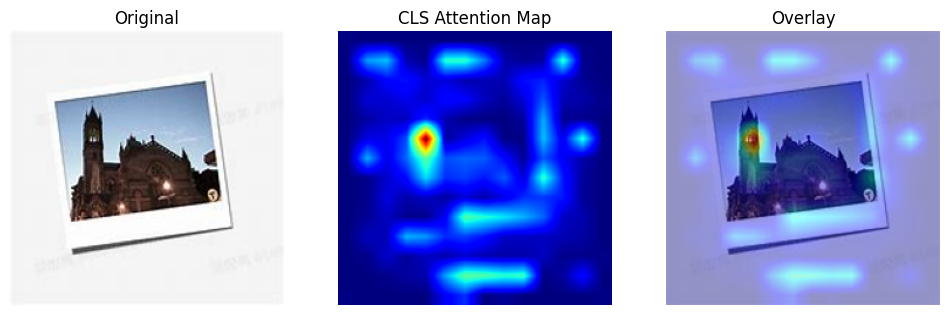

Embedding shape:  (1, 768)
前10维特征:  [-1.1446282   0.4479444  -0.9698104  -0.1089362   0.07386772  0.748882
  0.49805078 -0.5922615   0.30479807 -0.54076034]
用户:  exit


In [6]:
while True:
    img_path = input("\n用户：请输入图像路径")
    print("用户: ",img_path)
    if img_path.strip() == "exit":
        break
    visualize_cls_attention(img_path, model, processor)
    feature = extract_img_feature(img_path)
    print("Embedding shape: ",feature.shape)
    print("前10维特征: ",feature[0, :10])
    